In [193]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
gdrive/              model_plot.png  sample_data/
hvc_annotations.csv  resized/        saved_models/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd
import keras

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image 

from sklearn.model_selection import train_test_split
from keras.layers import AveragePooling2D
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import time


In [195]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
print(df.shape)

# one hot encoding of labels
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

print(one_hot_df.shape)
one_hot_df.head().T

(13573, 9)
(13573, 28)


,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.resize(cv2.imread(item["image_path"]),(200,200)) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
              
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [254]:
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=1)
train_df.shape, val_df.shape
#train_df.head() 

((11537, 28), (2036, 28))

In [255]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,shuffle=False)
valid_gen = PersonDataGenerator(val_df, batch_size=32,shuffle=False)

# get number of output units from data
images, targets = next(iter(train_gen))
images.shape

vimages, targets = next(iter(valid_gen))
print(f'A:{images.shape},B:{vimages.shape}')

num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

A:(32, 200, 200, 3),B:(32, 200, 200, 3)


{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
backbone = VGG16(
    weights=None,
    include_top=False, 
    input_tensor=Input(shape=(200, 200, 3))
)


neck = backbone.output
neck = AveragePooling2D()(neck)
neck = Flatten(name="flatten")(neck)


def build_tower(in_layer):
    #neck = Dropout(0.5)(in_layer)
    #neck = Flatten(name="flatten")(in_layer)
    neck = Dense(128, activation="relu")(in_layer)
    #neck = Dropout(0.5)(in_layer)
    #neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
   )

In [262]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
from keras.optimizers import Adam
#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) 19,437,787
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

# # freeze backbone
# for layer in backbone.layers:
# 	layer.trainable = False

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 200, 64) 1792        input_17[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 200, 200, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 100, 100, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.001 
    if epoch > 50:
        lr *= 0.1   
    if epoch > 40:
        lr *= 0.1
    elif epoch > 30:
        lr *= 0.1
    print('Learning rate: ', lr)
    return lr

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'custom_%s_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

def scheduler(epoch, lr):  return round(0.001 * 1/(1 + 0.319 * epoch), 10)

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint,  lr_scheduler]

In [267]:
#datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False,target_size=(200,200))

# Train the model
start = time.time()
model_info = model.fit_generator(generator=train_gen,
                                 epochs =50,
                                 use_multiprocessing=True,
                                 workers=1,
                                 validation_data = valid_gen,
                                 verbose=1,callbacks=callbacks)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

scores=model.evaluate_generator(valid_gen,verbose=1)
model.metrics_names
dict(zip(model.metrics_names,scores))


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
360/360 [==============================] - 81s 224ms/step - loss: 7.2697 - gender_output_loss: 0.5539 - image_quality_output_loss: 0.9686 - age_output_loss: 1.3934 - weight_output_loss: 0.9687 - bag_output_loss: 0.8753 - footwear_output_loss: 0.8389 - pose_output_loss: 0.7793 - emotion_output_loss: 0.8916 - gender_output_acc: 0.7143 - image_quality_output_acc: 0.5531 - age_output_acc: 0.4040 - weight_output_acc: 0.6348 - bag_output_acc: 0.5963 - footwear_output_acc: 0.6214 - pose_output_acc: 0.6642 - emotion_output_acc: 0.7161 - val_loss: 7.3702 - val_gender_output_loss: 0.5454 - val_image_quality_output_loss: 0.9684 - val_age_output_loss: 1.4171 - val_weight_output_loss: 0.9811 - val_bag_output_loss: 0.9284 - val_footwear_output_loss: 0.8419 - val_pose_output_loss: 0.7436 - val_emotion_output_loss: 0.9443 - val_gender_output_acc: 0.7282 - val_image_quality_output_acc: 0.5551 - val_age_output_acc: 0.3819 - v

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


360/360 [==============================] - 81s 225ms/step - loss: 7.0269 - gender_output_loss: 0.5078 - image_quality_output_loss: 0.9594 - age_output_loss: 1.3801 - weight_output_loss: 0.9551 - bag_output_loss: 0.8551 - footwear_output_loss: 0.8035 - pose_output_loss: 0.6887 - emotion_output_loss: 0.8771 - gender_output_acc: 0.7470 - image_quality_output_acc: 0.5541 - age_output_acc: 0.4082 - weight_output_acc: 0.6345 - bag_output_acc: 0.6103 - footwear_output_acc: 0.6463 - pose_output_acc: 0.7110 - emotion_output_acc: 0.7161 - val_loss: 7.2949 - val_gender_output_loss: 0.5104 - val_image_quality_output_loss: 0.9751 - val_age_output_loss: 1.4158 - val_weight_output_loss: 0.9673 - val_bag_output_loss: 0.8936 - val_footwear_output_loss: 0.8140 - val_pose_output_loss: 0.7305 - val_emotion_output_loss: 0.9883 - val_gender_output_acc: 0.7480 - val_image_quality_output_acc: 0.5486 - val_age_output_acc: 0.3839 - val_weight_output_acc: 0.6429 - val_bag_output_acc: 0.5843 - val_footwear_output

{'age_output_acc': 0.3288690476190476,
 'age_output_loss': 6.167145479293096,
 'bag_output_acc': 0.6150793650793651,
 'bag_output_loss': 3.9418500245563566,
 'emotion_output_acc': 0.6319444444444444,
 'emotion_output_loss': 4.025106123515537,
 'footwear_output_acc': 0.6165674603174603,
 'footwear_output_loss': 3.712950061238001,
 'gender_output_acc': 0.8025793650793651,
 'gender_output_loss': 2.0916954170143796,
 'image_quality_output_acc': 0.4965277777777778,
 'image_quality_output_loss': 4.460712728046236,
 'loss': 31.024224901956224,
 'pose_output_acc': 0.7718253968253969,
 'pose_output_loss': 2.4811123053705884,
 'weight_output_acc': 0.5877976190476191,
 'weight_output_loss': 4.143652651045057}

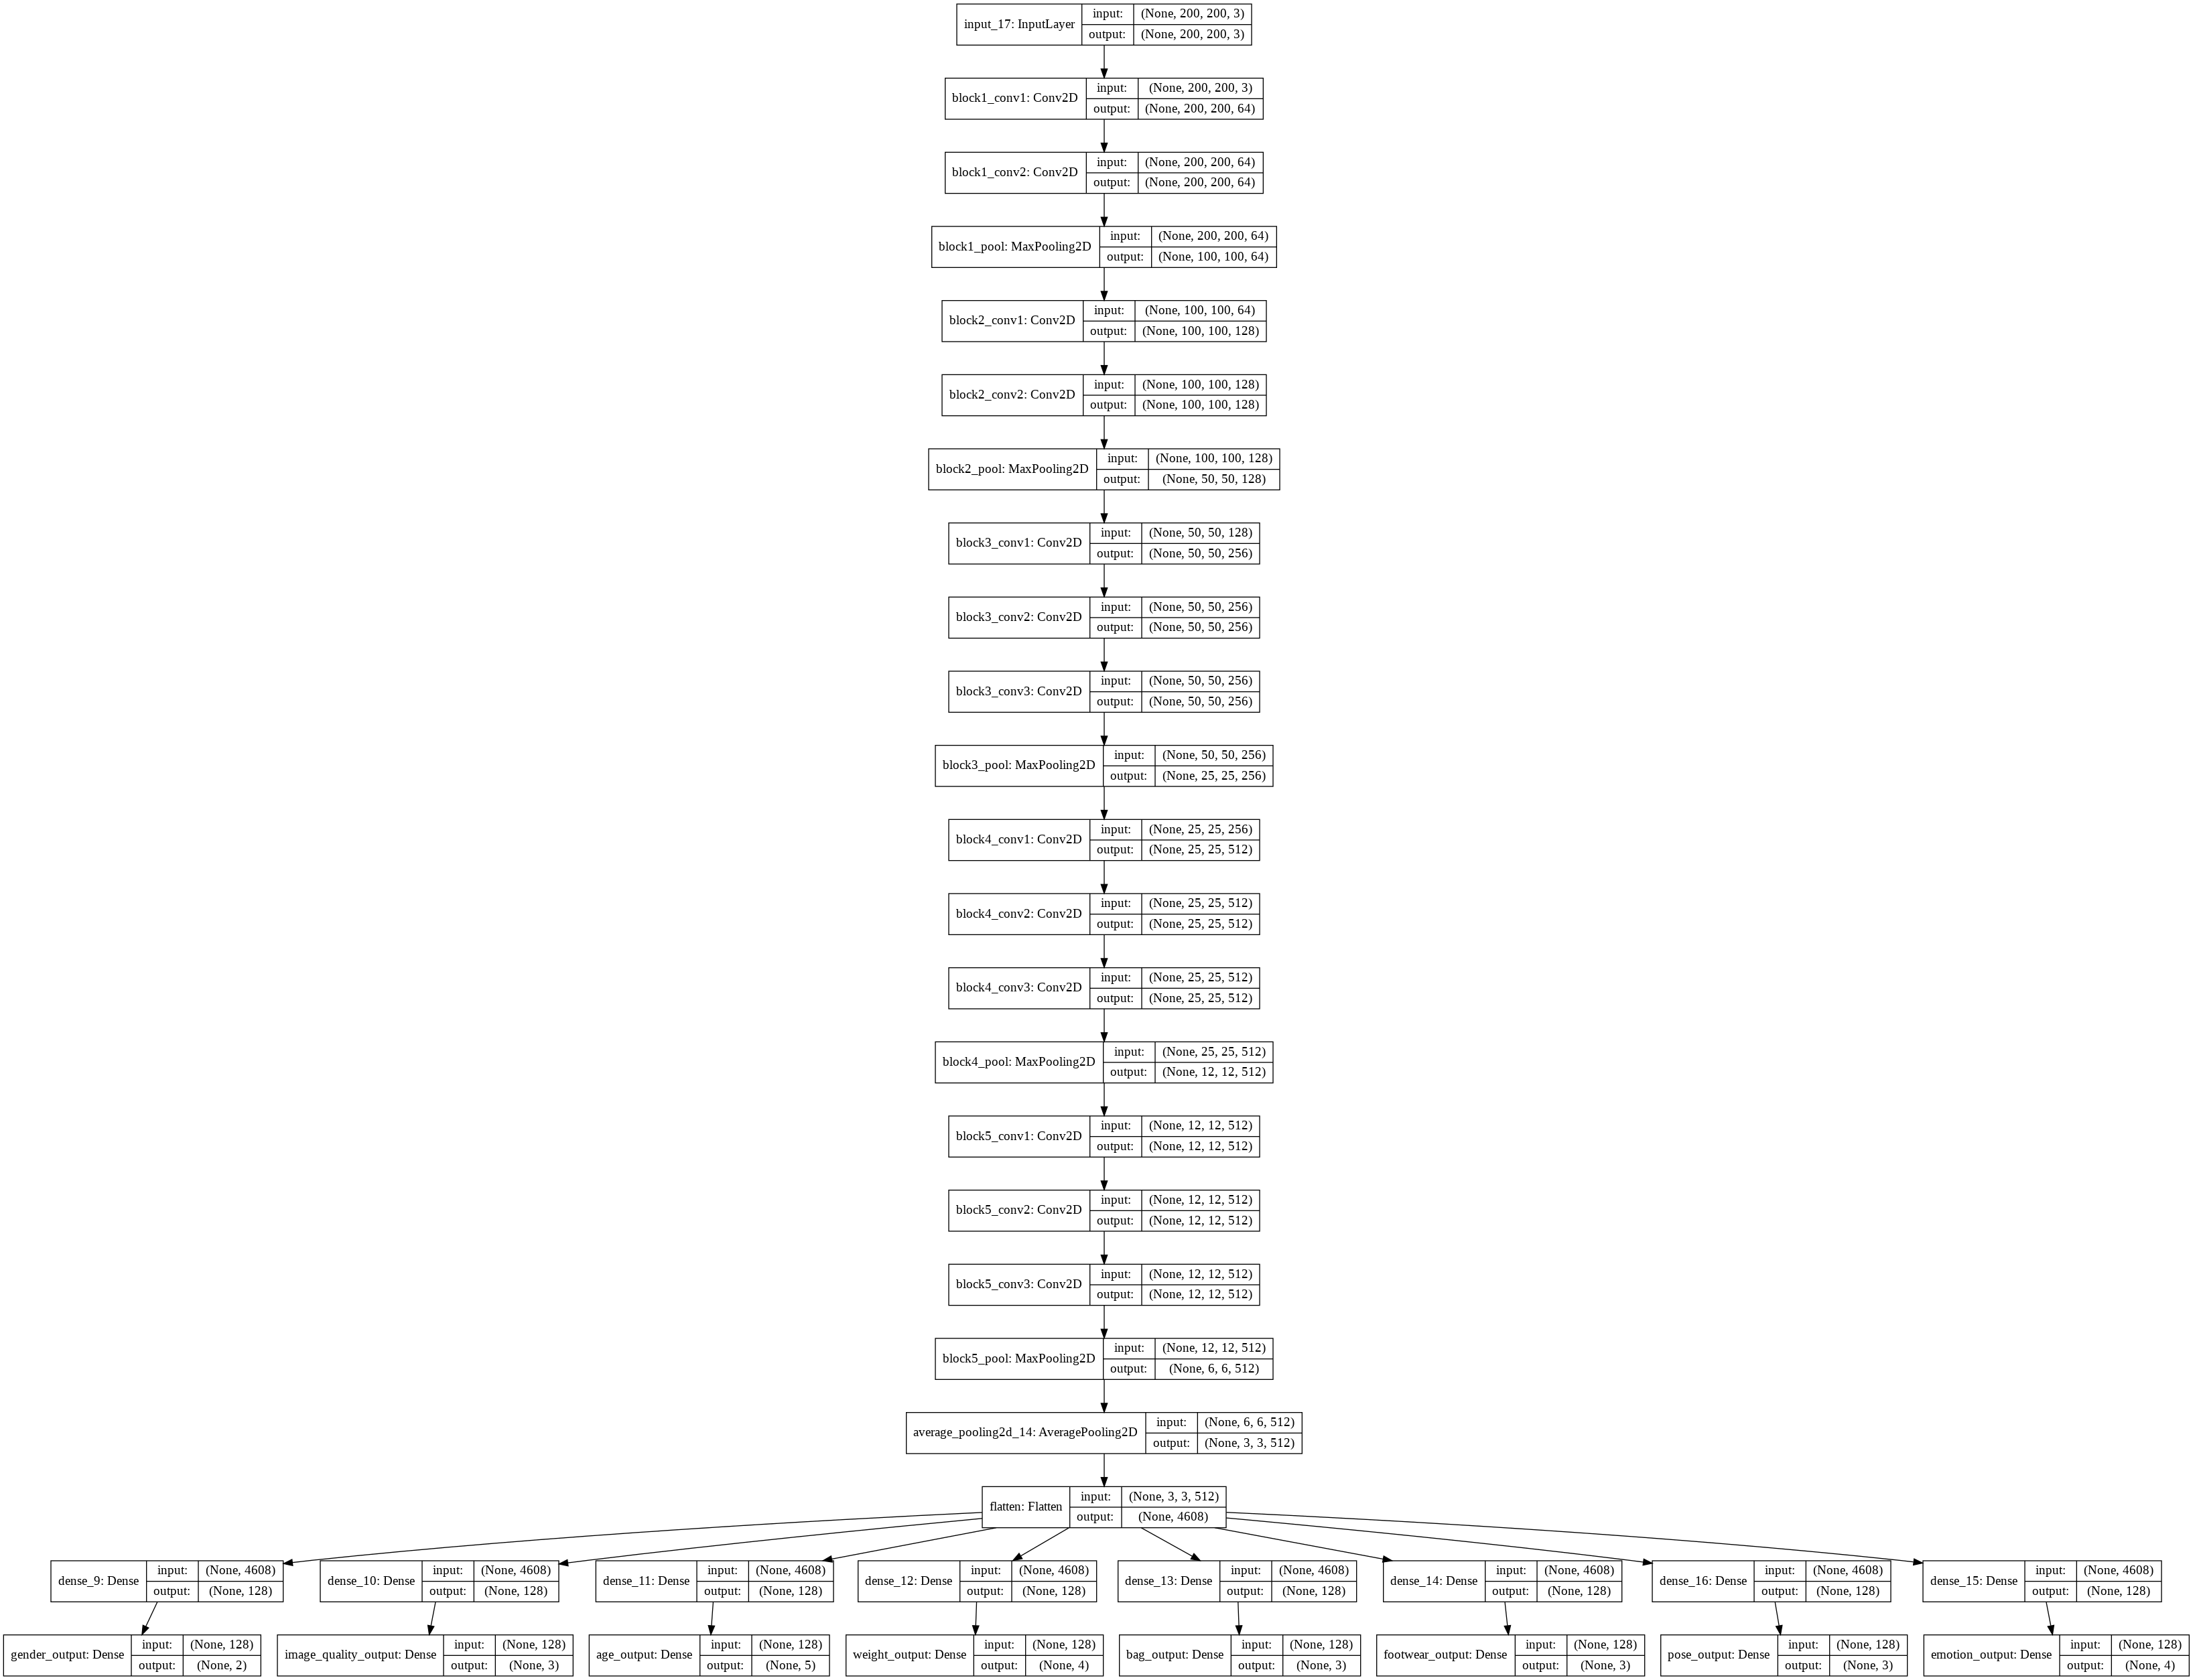

In [266]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model_plot.png',show_shapes=True, show_layer_names=True)